### модель фед ресурса MVP
Используются только 2 фичи: no_contracts_total,  bad_reasons_closed

Входные данные 
- data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи на target
- data/interm/accounts_status.pkl с общей категорией

In [1]:
import pandas as pd

In [2]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [3]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))
# target_features.head(1)

Размер считанных данных target_class with mdm features- (85798, 39)


In [4]:
name = pre + "data/interm/accounts_status.pkl"
accounts_status = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных о контрагентах (сводно из DWH и 1c) - {}".format(accounts_status.shape))
# accounts_status.head(1)

Размер считанных данных о контрагентах (сводно из DWH и 1c) - (737858, 4)


In [5]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/mvp_model.xlsx"
writer = ExcelWriter(name)

#### Теперь формируем выборки для фрод и дефолта

In [6]:
target_frod = Target(type='фрод', target_data=target_features, removeMajorClients=True) # это фрод дефолт, макс по обращению без крупных клиентов

target_frod.print_param()

target_cred = Target(type='кред', target_data=target_features, removeMajorClients=True) # это кред дефолт, макс по обращению без крупных клиентов

target_cred.print_param()


Параметры обработанной таблицы портфеля рисков  по обращениям:
	фрод дефолт = 1  у выборки 4428 из 54288 (8.16%)

Параметры обработанной таблицы портфеля рисков  по обращениям:
	кред дефолт = 1  у выборки 1566 из 37898 (4.13%)


В обучающей выборке удалим все outliers. 

В случае, когда распределение более 95% около 0, то такое распределение будет считаться не содержит outliers. 

In [7]:
keep_columns = ['Приложение', 'Метка дефолта', 'Дата принятия решения по сделке', 'no_contracts_total', 'bad_reasons_closed']

def remove_outliers(df):

   for feature in keep_columns:
      if feature in ['Приложение', 'Метка дефолта', 'Дата принятия решения по сделке']:
         continue

      percentile_max = 1 if feature in ['reason_замена/перенайм/переуступка', 'reason_определена цессия', 
                                          'reason_расторгнут', 'reason_страховой случай', 'reason_страховой случай (гибель/тотал)', 
                                          'reason_гибель/тотал', 'bad_reasons_closed'] else 0.99
                                          
      df[feature] = replace_outliers_with_none_quantile(df[feature], upper = percentile_max)
      
   df = df.dropna()
   return df

features_wo_outliers = target_cred.data[keep_columns].copy()

target_cred.data = remove_outliers(features_wo_outliers)
target_cred.print_param()

data_test = features_wo_outliers[features_wo_outliers['Дата принятия решения по сделке']>='01.07.2022']
print('доля дефолта в тестовой выборке {}'.format(round(len(data_test[data_test['Метка дефолта']==1])/len(data_test)*100, 2)))

features_wo_outliers = target_frod.data[keep_columns].copy()

target_frod.data = remove_outliers(features_wo_outliers)
target_frod.print_param()
data_test = features_wo_outliers[features_wo_outliers['Дата принятия решения по сделке']>='01.07.2022']
print('доля дефолта в тестовой выборке {}'.format(round(len(data_test[data_test['Метка дефолта']==1])/len(data_test)*100, 2)))


Параметры обработанной таблицы портфеля рисков  по обращениям:
	кред дефолт = 1  у выборки 1561 из 37527 (4.16%)
доля дефолта в тестовой выборке 16.33

Параметры обработанной таблицы портфеля рисков  по обращениям:
	фрод дефолт = 1  у выборки 4420 из 53749 (8.22%)
доля дефолта в тестовой выборке 11.43


### Модель строится на фрод дефолте

Взаимное распределения фичей

In [8]:
features_wo_outliers_frod = target_frod.data
# features_wo_outliers_frod.head()
features_wo_outliers_frod['Метка дефолта '] = features_wo_outliers_frod['Метка дефолта'].astype(str)

для pair-plot важно показать что одному значению может быть и 0 и 1,   
значит цвет должен непрерывно быть изменен в зависимости от среднего.  
но среднее у нас imbalanced  
поэтому сначала найдем balanced среднее, для визуализации  

In [9]:
classes = np.unique(features_wo_outliers_frod['Метка дефолта'])
y = np.array(features_wo_outliers_frod['Метка дефолта'])
class_weights = sk_class_weight.compute_class_weight(class_weight = 'balanced', classes = classes, y = y)
class_weights

array([0.54480123, 6.08020362])

In [10]:
map_dict = { cl:weight for cl, weight in zip(classes, class_weights)}
features_weight = features_wo_outliers_frod[['no_contracts_total','bad_reasons_closed', 'Метка дефолта']]
features_weight['weight'] = features_weight['Метка дефолта'].map(map_dict)
features_weight.sample(2)

,no_contracts_total,bad_reasons_closed,Метка дефолта,weight
44670,0.0,0.0,0,0.544801
21115,2.0,0.0,0,0.544801


In [11]:
df_weight = features_weight.groupby(['no_contracts_total','bad_reasons_closed']).apply(lambda grp: (grp['Метка дефолта']*grp['weight']).sum() / grp['weight'].sum())
df_weight = df_weight.reset_index().rename(columns = {0:'mean_weighted'})
df_weight['mean_weighted'] = round(df_weight['mean_weighted'], 2)
df_weight.head(2)

,no_contracts_total,bad_reasons_closed,mean_weighted
0,0.0,0.0,0.68
1,1.0,0.0,0.37


In [12]:
# как оформляли цвета
quantiles = []
for i in range(0, 11):
    quantiles.append(round(df_weight['mean_weighted'].quantile(i/10), 2))
quantiles
255/100*np.array([0, 20, 32, 41, 59, 86, 100])

array([  0.  ,  51.  ,  81.6 , 104.55, 150.45, 219.3 , 255.  ])

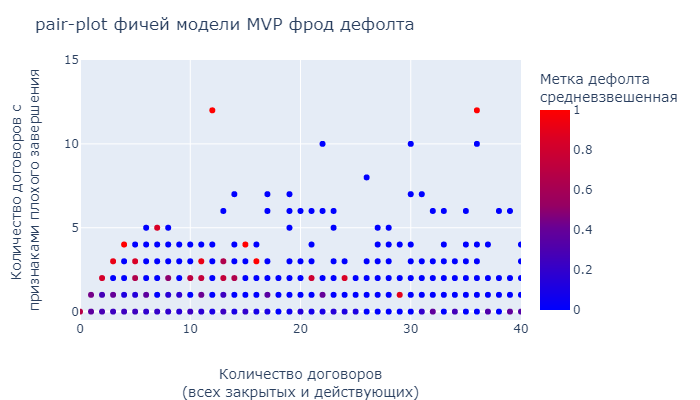

In [13]:
# делаем шкалу одну на кред и фрод дефолты
colorscale=[[0.0, "rgb(0, 0, 255)"],
                [0.20, "rgb(51, 0, 204)"],
                [0.32, "rgb(82, 0, 170)"],
                [0.41, "rgb(104, 0, 150)"],
                [0.52, "rgb(150, 0, 100)"],
                [0.86, "rgb(219, 0, 36)"],
                [1.0, "rgb(255, 0, 0)"]]



kwargs = dict(title='pair-plot фичей модели MVP фрод дефолта', 
                x_range = [0, 40], y_range = [-0.5, 15],
                x_feature='no_contracts_total', y_feature='bad_reasons_closed',
                x_title = get_feature_name('no_contracts_total', 'title'), y_title = get_feature_name('bad_reasons_closed', 'title'), 
                width =700, height= 400, 
                df = df_weight, 
                colorscale = colorscale, color = 'mean_weighted', 
                labels={'mean_weighted': 'Метка дефолта'+'<br>'+ 'средневзвешенная'})

fig_pairplot_frod = create_plot(cpPairplot, **kwargs)
fig_pairplot_frod.show('png' if need_svg else '')

## Обучение модели на target
### Фича no_contracts_total - "Количество договоров до дня принятия решения" на Фрод выборке

используется эта фича так как эти данные имеют наибольший AUC в однофактоной анализе LogRegression

In [14]:
classes_frod = ['фрод дефолт=0', 'фрод дефолт=1']
# features_wo_outliers_frod.head(1)

{'rocauc': 0.66, 'accuracy': 0.5, 'recall': 0.87}
{'intercept': -0.0269, 'coef': array([-0.2678])}


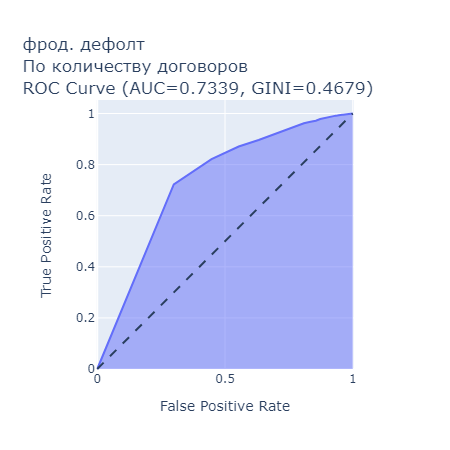

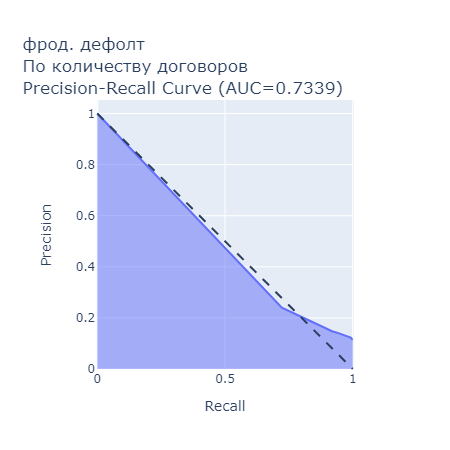

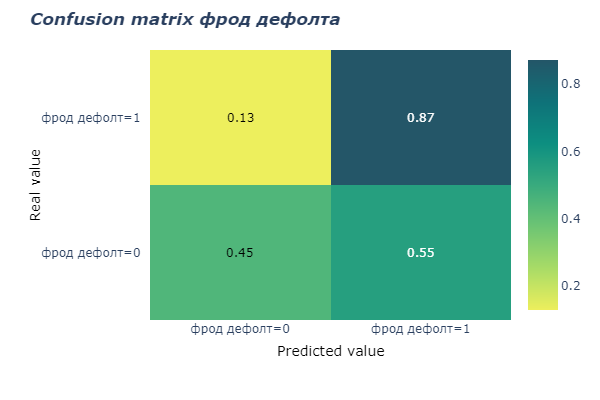

In [15]:
data = features_wo_outliers_frod.copy()
type_default = 'фрод'

data_train = data[data['Дата принятия решения по сделке']<'01.07.2022'].copy()
data_test = data[data['Дата принятия решения по сделке']>='01.07.2022'].copy()

X_train = data_train[['no_contracts_total']]
X_test = data_test[['no_contracts_total']]
y_train = data_train['Метка дефолта']
y_test = data_test['Метка дефолта']

kwargs = {'need_to_split':False, 'scoring':'recall'}
log = LogRegCV(X_raw = X_train, y_raw=y_train, X_test=X_test, y_test=y_test, **kwargs)

log.print_metrics()
log.print_coef()
fig_roc_auc = log.plot_roc_curve(title = '{}. дефолт'.format(type_default) + '<br>' +'По количеству договоров')


fig_precision_recall = log.plot_precision_recall(title = '{}. дефолт'.format(type_default) + '<br>' +'По количеству договоров')

fig_matrix_frod = log.plot_confusion_matrix(normalize='true',  colorscale='Aggrnyl_r', 
                                            title='Confusion matrix фрод дефолта',  classes=classes_frod)



{'rocauc': 0.66, 'accuracy': 0.5, 'recall': 0.87}
{'intercept': -0.027, 'coef': array([-0.2669, -0.0093])}


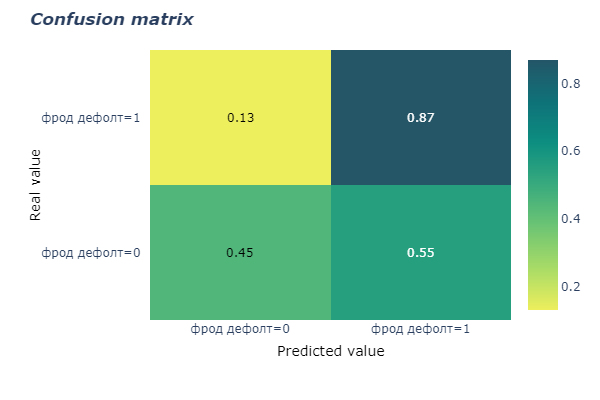

In [16]:
data = features_wo_outliers_frod.copy()

data_train = data[data['Дата принятия решения по сделке']<'01.07.2022'].copy()
data_test = data[data['Дата принятия решения по сделке']>='01.07.2022'].copy()

X_train = data_train[['no_contracts_total', 'bad_reasons_closed']]
X_test = data_test[['no_contracts_total', 'bad_reasons_closed']]
y_train = data_train['Метка дефолта']
y_test = data_test['Метка дефолта']

kwargs = {'need_to_split':False,  'scoring':'recall'}
log = LogRegCV(X_train, y_train, X_test=X_test, y_test=y_test, **kwargs)

log.print_metrics()
log.print_coef()
fig = log.plot_confusion_matrix(normalize='true',  colorscale='Aggrnyl_r',  classes=classes_frod)

смотрим, на те, у кого количество плохих дефолтов>0

In [17]:
mask = (features_wo_outliers_frod['bad_reasons_closed']>0)
data_branch_1 = features_wo_outliers_frod[mask].copy()
data_branch_1['Метка дефолта'] = data_branch_1['Метка дефолта'].astype(str)

X = data_branch_1[['no_contracts_total', 'bad_reasons_closed']]
log.predict(X)
data_branch_1['y_pred'], data_branch_1['y_prob']= log.predict(X)

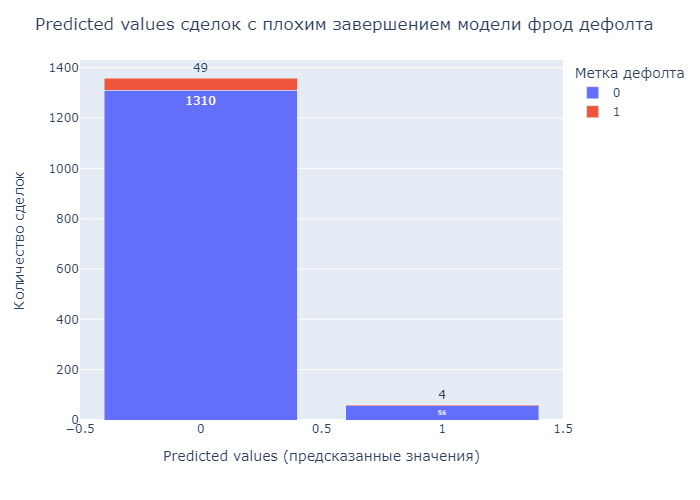

In [18]:
kwargs = dict(df=data_branch_1, title='Predicted values сделок с плохим завершением модели фрод дефолта', 
                x_title='Predicted values (предсказанные значения)', y_title='Количество сделок')
    
fig = create_plot(cpPredictedBadCases, **kwargs)
fig.show('png' if need_svg else '')

Несмотря на то, что коэффициенты у лог регрессии противоположны {'intercept': -0.037, 'coef': array([-0.32  ,  0.0032])},
что значит, чем больше 'no_contracts_total', тем менее вероятно, что это дефолт, и наоборот, чем больше 'bad_reasons_closed', тем более вероятно, что это дефолт.

тем не менее, большинство контрагентов с признаками плохого завершения были признаны не дефолтными.

Поэтому рассмотрим вариант, когда все контрагенты, у кого есть признаки плохого завершения, считаем дефолтными

### Модель с ветвлением: 

у кого есть признаки плохого завершения, считаем дефолтными:

'bad_reasons_closed'>0  
'y_prob' = 1  
'y_pred' = 1  

остальные прогоняем через лог регрессию по фиче 'no_contracts_total'

{'rocauc': 0.65, 'accuracy': 0.47, 'recall': 0.88}
{'intercept': -0.027, 'coef': array([-0.2694])}


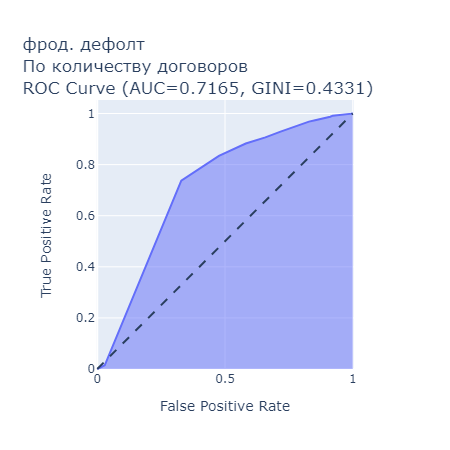

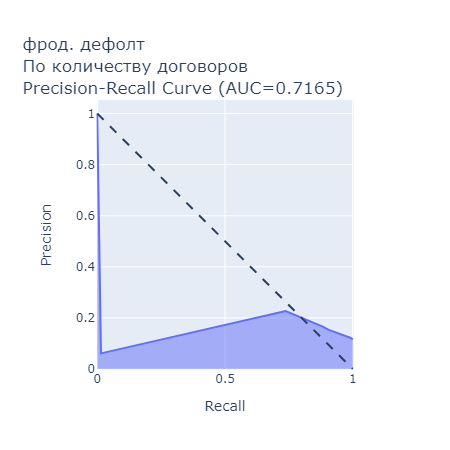

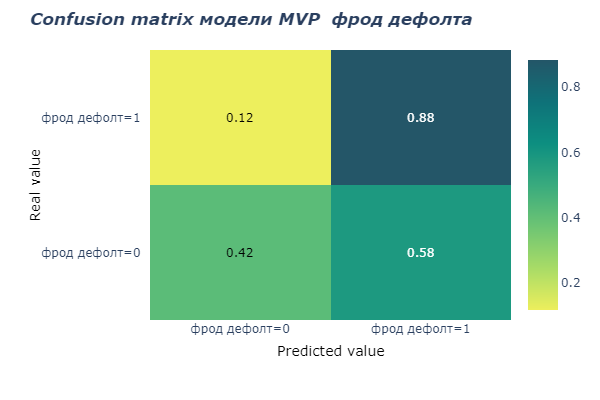

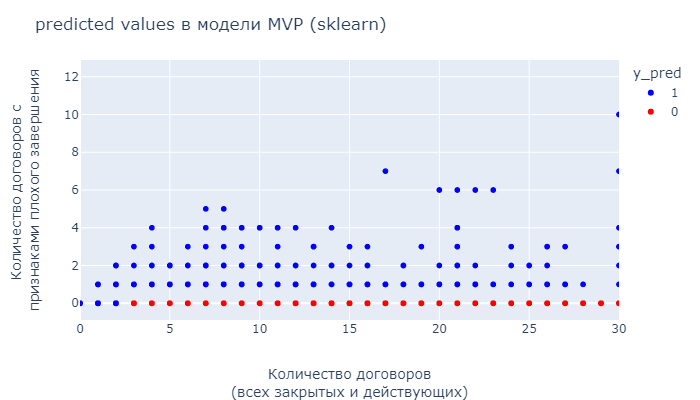

In [19]:
data = features_wo_outliers_frod.copy()
type_default = 'фрод'

data_train = data[data['Дата принятия решения по сделке']<'01.07.2022'].copy()
data_test = data[data['Дата принятия решения по сделке']>='01.07.2022'].copy()

kwargs = {'scoring':'recall'}

model_mvp = Branch(data_train, data_test, **kwargs)

model_mvp.print_metrics()
model_mvp.log.print_coef()

fig_roc_auc = model_mvp.plot_roc_curve(title = '{}. дефолт'.format(type_default) + '<br>' +'По количеству договоров')

fig_precision_recall = model_mvp.plot_precision_recall(title = '{}. дефолт'.format(type_default) + '<br>' +'По количеству договоров')

fig_confusion_frod = model_mvp.plot_confusion_matrix(normalize='true',  colorscale='Aggrnyl_r', 
                                                     title='Confusion matrix модели MVP  фрод дефолта',  classes=classes_frod)

data_test['y_pred '] = model_mvp.y_pred.astype(int).astype(str)
fig = show_model_multifactors(data_test, x_feature='no_contracts_total', y_feature='bad_reasons_closed', 
                                title='predicted values в модели MVP (sklearn)', color='y_pred ', 
                                color_discrete_sequence = [ "blue", "red"], 
                                x_range = [0, 30])


## Считаем долю дефолта и другие метрики качества на target данных суммарно в пуле



In [20]:
data = features_wo_outliers_frod.copy()

data_train = data[(data['Дата принятия решения по сделке']<'01.07.2022')].copy()
data_test = data[data['Дата принятия решения по сделке']>='01.07.2022'].copy()

kwargs = {'scoring':'recall'}

model_mvp = Branch(data_train, data_test, **kwargs)

model_mvp.print_metrics()
model_mvp.log.print_coef()

{'rocauc': 0.65, 'accuracy': 0.47, 'recall': 0.88}
{'intercept': -0.027, 'coef': array([-0.2694])}


In [21]:
test_res = data_test.copy()
y_pred, y_prob = model_mvp.predict(test_res)
test_res['y_pred'] = y_pred
test_res['y_prob'] = y_prob

df_metrics = pd.DataFrame(columns=['proba', 'Доля_дефолта_в_target'])
lstProb = list(set(sorted(round(test_res['y_prob'],3))))
share_of_fraud_last = 0

for proba in tqdm(lstProb):

    mask = (test_res['y_prob']<=proba)
    test_res.loc[mask, 'y_pred'] = 0
    test_res.loc[~mask, 'y_pred'] = 1

    good = test_res[mask]
    share_of_uzdl = len(good)/len(test_res)
    
    if (len(good)==0):
        continue
    share_of_fraud = good['Метка дефолта'].sum()/len(good)
    if abs(share_of_fraud_last-share_of_fraud)<0.0001:
        continue
    share_of_fraud_last = share_of_fraud
    d = {'proba': proba, 'Доля_дефолта_в_target':share_of_fraud, 'Доля_УЗДЛ':share_of_uzdl}
    df_metrics = df_metrics.append(d, ignore_index=True)
    
df_metrics["Доля_дефолта_в_target_proc"] = df_metrics["Доля_дефолта_в_target"]*100

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:00<00:00, 466.56it/s]


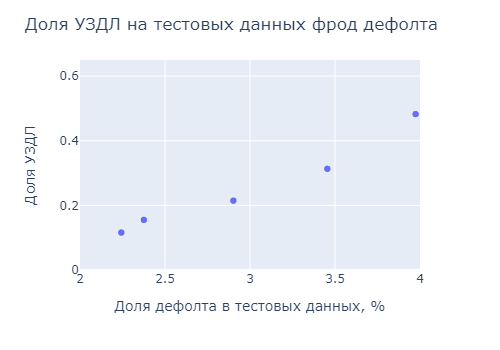

In [22]:
kwargs = dict(title='Доля УЗДЛ на тестовых данных фрод дефолта', 
                x_title='Доля дефолта в тестовых данных, %', y_title='Доля УЗДЛ', 
                x_range=[2, 4], y_range=[0, 0.65], 
                height= 350, width =500, 
                df = df_metrics[df_metrics['proba']>0.24].copy())
    
fig_share_uzdl_frod = create_plot(cpShareUzdlvTestDefaul, **kwargs)
fig_share_uzdl_frod.show('png' if need_svg else '')

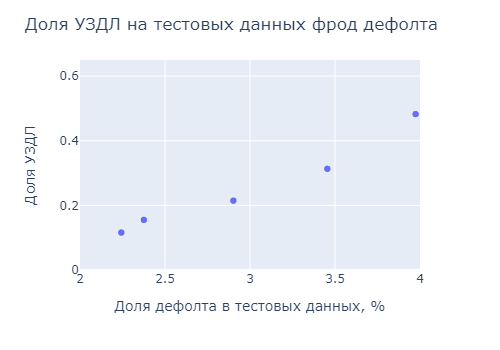

In [23]:
kwargs = dict(title='Доля УЗДЛ на тестовых данных фрод дефолта', 
                x_title='Доля дефолта в тестовых данных, %', y_title='Доля УЗДЛ', 
                x_range=[2, 4], y_range=[0, 0.65], 
                height= 350, width =500, 
                df = df_metrics[df_metrics['proba']>0.24].copy())
    
fig_share_uzdl_frod = create_plot(cpShareUzdlvTestDefaul, **kwargs)
fig_share_uzdl_frod.show('png' if need_svg else '')

определим proba для 2% в пуле

In [24]:
cut_proba = df_metrics[df_metrics['Доля_дефолта_в_target_proc']<=2]['proba'].max()
cut_proba

0.281

In [25]:
def show_pred_versus_shareDefaults(metrics, df_res, shareDefaults, title):
    cut_proba = metrics[metrics['Доля_дефолта_в_target_proc']<=shareDefaults]['proba'].max()
    share_of_uzdl = round(metrics[metrics['Доля_дефолта_в_target_proc']<=shareDefaults]['Доля_УЗДЛ'].max(), 2)
    
    df_res['y_pred'] = np.where(df_res['y_prob']<=cut_proba, '0', '1')
    title = title + ' {}% (доля УЗДЛ {})'.format(shareDefaults, share_of_uzdl)
    
    fig = show_model_multifactors(df_res, x_feature='no_contracts_total', y_feature='bad_reasons_closed', 
                                title=title, color='y_pred', 
                                color_discrete_sequence = [ "blue", "red"], 
                                x_range = [0, 30])
    return fig

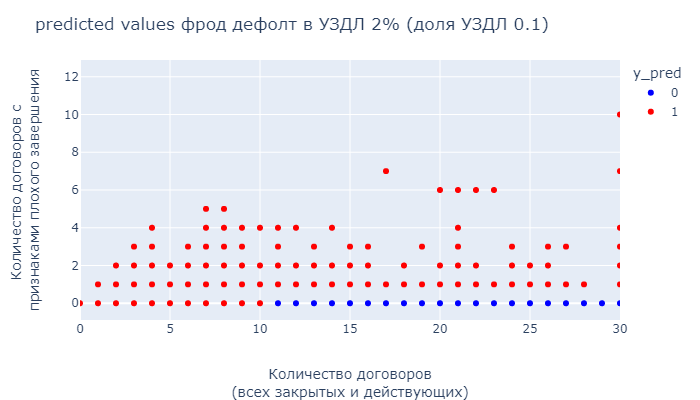

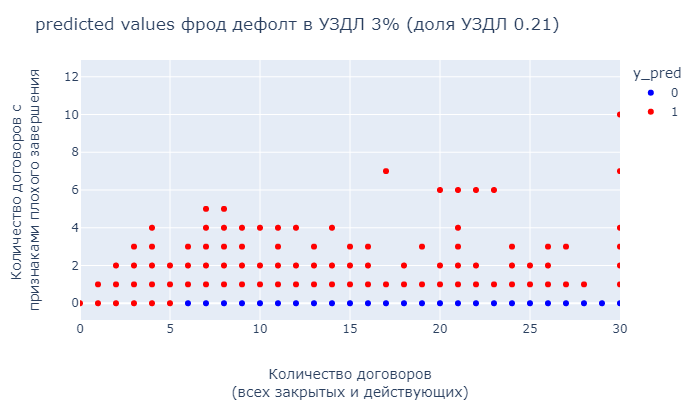

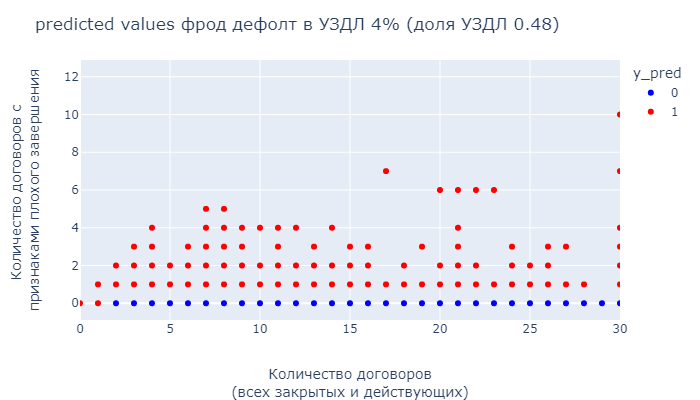

In [26]:
test_res = data_test.copy()
y_pred, y_prob = model_mvp.predict(test_res)
test_res['y_pred'] = y_pred.astype(str)
test_res['y_prob'] = y_prob

df = test_res.drop_duplicates(subset=['no_contracts_total', 'bad_reasons_closed', 'y_pred', 'y_prob'])

fig = show_pred_versus_shareDefaults(df_metrics, df,  2, title='predicted values фрод дефолт в УЗДЛ')
fig = show_pred_versus_shareDefaults(df_metrics, df, 3, title='predicted values фрод дефолт в УЗДЛ')
fig_pred_values_frod = show_pred_versus_shareDefaults(df_metrics, df, 4, title='predicted values фрод дефолт в УЗДЛ')


# Модель кред дефолта

Взаимное распределения фичей

In [27]:
features_wo_outliers_cred = target_cred.data
# features_wo_outliers_cred.head()
features_wo_outliers_cred['Метка дефолта '] = features_wo_outliers_cred['Метка дефолта'].astype(str)

In [28]:
classes = np.unique(features_wo_outliers_cred['Метка дефолта'])
y = np.array(features_wo_outliers_cred['Метка дефолта'])
class_weights = sk_class_weight.compute_class_weight(class_weight = 'balanced', classes = classes, y = y)
class_weights

array([ 0.52170105, 12.02017937])

In [29]:
map_dict = { cl:weight for cl, weight in zip(classes, class_weights)}
features_weight = features_wo_outliers_cred[['no_contracts_total','bad_reasons_closed', 'Метка дефолта']]
features_weight['weight'] = features_weight['Метка дефолта'].map(map_dict)

df_weight = features_weight.groupby(['no_contracts_total','bad_reasons_closed']).apply(lambda grp: (grp['Метка дефолта']*grp['weight']).sum() / grp['weight'].sum())
df_weight = df_weight.reset_index().rename(columns = {0:'mean_weighted'})
df_weight['mean_weighted'] = round(df_weight['mean_weighted'], 2)
df_weight.head(2)

,no_contracts_total,bad_reasons_closed,mean_weighted
0,0.0,0.0,0.59
1,1.0,0.0,0.45


In [30]:
# как оформляли цвета
quantiles = []
for i in range(0, 11):
    quantiles.append(round(df_weight['mean_weighted'].quantile(i/10), 2))
quantiles

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.52, 0.86, 1.0]

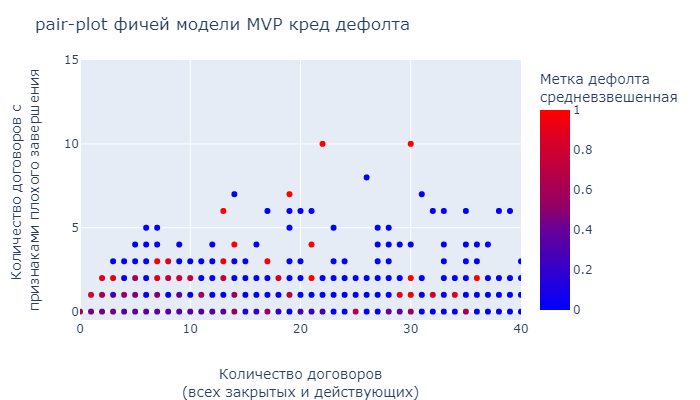

In [31]:
colorscale=[[0.0, "rgb(0, 0, 255)"],
                [0.20, "rgb(51, 0, 204)"],
                [0.32, "rgb(82, 0, 170)"],
                [0.41, "rgb(104, 0, 150)"],
                [0.52, "rgb(150, 0, 100)"],
                [0.86, "rgb(219, 0, 36)"],
                [1.0, "rgb(255, 0, 0)"]]


kwargs = dict(df = df_weight, 
              title='pair-plot фичей модели MVP кред дефолта', 
                x_range = [0, 40], y_range = [-0.5, 15],
                x_feature='no_contracts_total', y_feature='bad_reasons_closed',
                x_title = get_feature_name('no_contracts_total', 'title'), y_title = get_feature_name('bad_reasons_closed', 'title'), 
                width =700, height= 400, 
                colorscale = colorscale, color = 'mean_weighted', 
                labels={'mean_weighted': 'Метка дефолта'+'<br>'+ 'средневзвешенная'})

fig_pairplot_cred = create_plot(cpPairplot, **kwargs)
fig_pairplot_cred.show('png' if need_svg else '')

In [32]:
# fig = pair_subplots2(fig_pairplot_frod, fig_pairplot_cred)
# fig.write_image(pre+'data/img/pair_plot_MVP.png')

## Обучение модели на target
### Фича no_contracts_total - "Количество договоров до дня принятия решения" на кред выборке

используется эта фича так как эти данные имеют наибольший AUC в однофактоной анализе LogRegression

In [33]:
classes_cred = ['кред дефолт=0', 'кред дефолт=1']
# features_wo_outliers_cred.head(1)

{'rocauc': 0.58, 'accuracy': 0.48, 'recall': 0.72}
{'intercept': -0.0074, 'coef': array([-0.1294])}


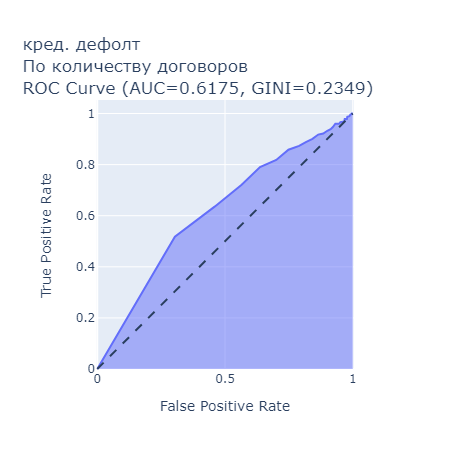

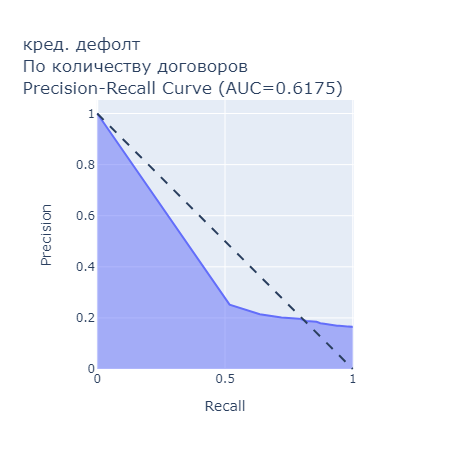

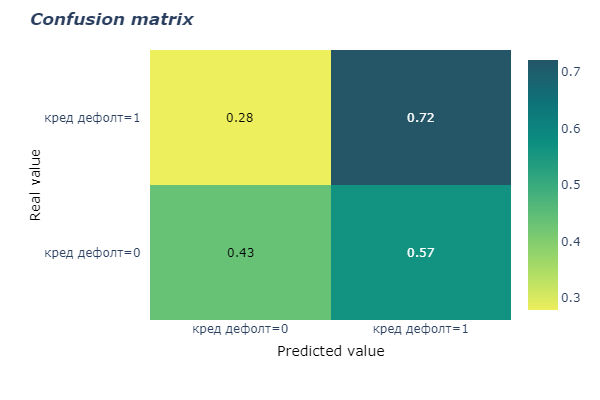

In [34]:
data = features_wo_outliers_cred.copy()
type_default = 'кред'

data_train = data[data['Дата принятия решения по сделке']<'01.07.2022'].copy()
data_test = data[data['Дата принятия решения по сделке']>='01.07.2022'].copy()

X_train = data_train[['no_contracts_total']]
X_test = data_test[['no_contracts_total']]
y_train = data_train['Метка дефолта']
y_test = data_test['Метка дефолта']

kwargs = {'need_to_split':False, 'scoring':'recall'}
log = LogRegCV(X_train, y_train, X_test=X_test, y_test=y_test, **kwargs)

log.print_metrics()
log.print_coef()
fig_roc_auc = log.plot_roc_curve(title = '{}. дефолт'.format(type_default) + '<br>' +'По количеству договоров')

fig_precision_recall = log.plot_precision_recall(title = '{}. дефолт'.format(type_default) + '<br>' +'По количеству договоров')

fig = log.plot_confusion_matrix(normalize='true',  colorscale='Aggrnyl_r', classes=classes_cred)

{'rocauc': 0.59, 'accuracy': 0.47, 'recall': 0.75}
{'intercept': -0.0094, 'coef': array([-0.14  ,  0.0512])}


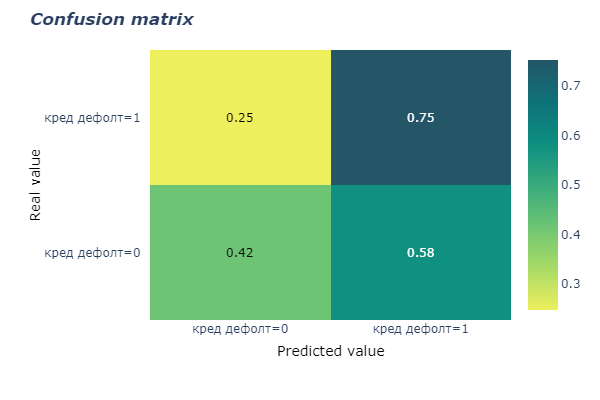

In [35]:
data = features_wo_outliers_cred.copy()
type_default = 'кред'

data_train = data[data['Дата принятия решения по сделке']<'01.07.2022'].copy()
data_test = data[data['Дата принятия решения по сделке']>='01.07.2022'].copy()

X_train = data_train[['no_contracts_total', 'bad_reasons_closed']]
X_test = data_test[['no_contracts_total', 'bad_reasons_closed']]
y_train = data_train['Метка дефолта']
y_test = data_test['Метка дефолта']

kwargs = {'scoring':'recall'}
log = LogRegCV(X_train, y_train, X_test=X_test, y_test=y_test, **kwargs)

log.print_metrics()
log.print_coef()
fig = log.plot_confusion_matrix(normalize='true',  colorscale='Aggrnyl_r', classes=classes_cred)

### Модель с ветвлением: 

у кого есть признаки плохого завершения, считаем дефолтными:

'bad_reasons_closed'>0  
'y_prob' = 1  
'y_pred' = 1  

остальные прогоняем через лог регрессию по фиче 'no_contracts_total'

{'rocauc': 0.59, 'accuracy': 0.47, 'recall': 0.76}
{'intercept': -0.0094, 'coef': array([-0.1484])}


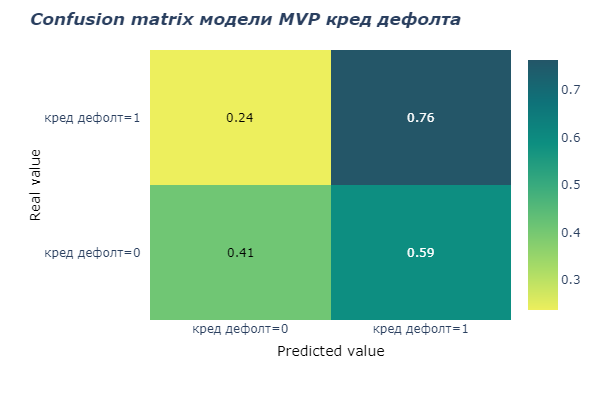

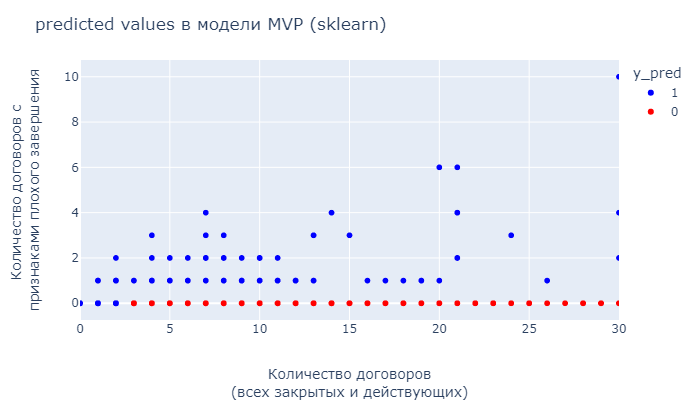

In [36]:
data = features_wo_outliers_cred.copy()
type_default = 'кред'

data_train = data[data['Дата принятия решения по сделке']<'01.07.2022'].copy()
data_test = data[data['Дата принятия решения по сделке']>='01.07.2022'].copy()

kwargs = {'scoring':'recall'}

model_mvp = Branch(data_train, data_test, **kwargs)

model_mvp.print_metrics()
model_mvp.log.print_coef()
fig_confusion_cred = model_mvp.plot_confusion_matrix(normalize='true',  colorscale='Aggrnyl_r', 
                                                     title='Confusion matrix модели MVP кред дефолта', classes=classes_cred)

data_test['y_pred '] = model_mvp.y_pred.astype(int).astype(str)
fig = show_model_multifactors(data_test, x_feature='no_contracts_total', y_feature='bad_reasons_closed', 
                                title='predicted values в модели MVP (sklearn)', color='y_pred ', 
                                color_discrete_sequence = [ "blue", "red"], 
                                x_range = [0, 30])


{'rocauc': 0.59, 'accuracy': 0.47, 'recall': 0.76}
{'intercept': -0.0094, 'coef': array([-0.1484])}


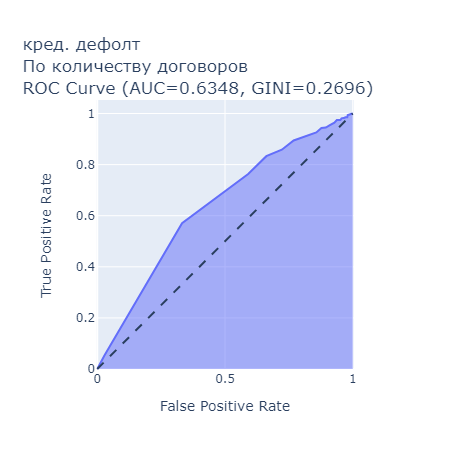

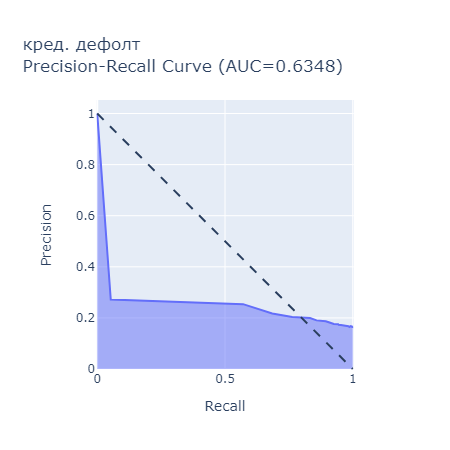

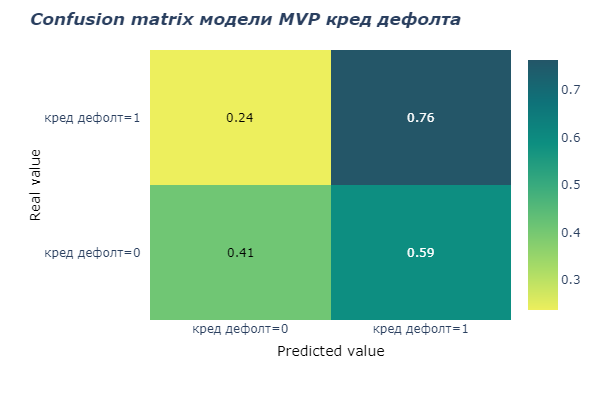

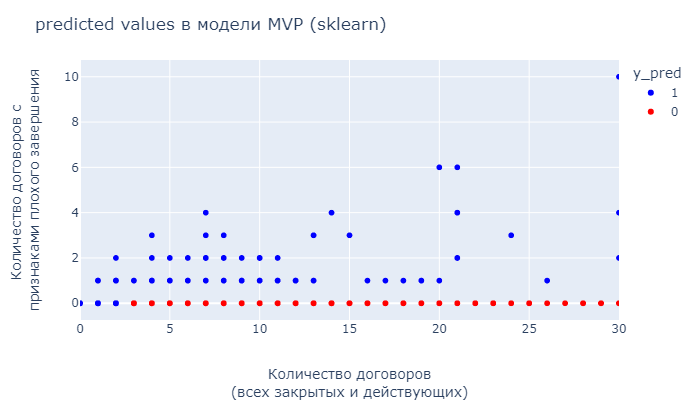

In [37]:
data = features_wo_outliers_cred.copy()
type_default = 'кред'

data_train = data[data['Дата принятия решения по сделке']<'01.07.2022'].copy()
data_test = data[data['Дата принятия решения по сделке']>='01.07.2022'].copy()

kwargs = {'scoring':'recall'}

model_mvp = Branch(data_train, data_test, **kwargs)

model_mvp.print_metrics()
model_mvp.log.print_coef()

fig_roc_auc = model_mvp.plot_roc_curve(title = '{}. дефолт'.format(type_default) + '<br>' +'По количеству договоров')

fig_precision_recall = model_mvp.plot_precision_recall(title = '{}. дефолт'.format(type_default))

fig_confusion_cred = model_mvp.plot_confusion_matrix(normalize='true',  colorscale='Aggrnyl_r', 
                                                     title='Confusion matrix модели MVP кред дефолта', classes=classes_cred)

test_res = data_test.copy()
y_pred, y_prob = model_mvp.predict(test_res)

test_res['y_pred '] = y_pred.astype(int).astype(str)
fig = show_model_multifactors(test_res, x_feature='no_contracts_total', y_feature='bad_reasons_closed', 
                                title='predicted values в модели MVP (sklearn)', color='y_pred ', 
                                color_discrete_sequence = [ "blue", "red"], 
                                x_range = [0, 30])


In [38]:
test_res = data_test.copy()
y_pred, y_prob = model_mvp.predict(test_res)
test_res['y_pred'] = y_pred.astype(str)
test_res['y_prob'] = y_prob

df_metrics = pd.DataFrame(columns=['proba', 'Доля_дефолта_в_target'])
lstProb = list(set(sorted(round(test_res['y_prob'],3))))
share_of_fraud_last = 0

for proba in tqdm(lstProb):

    mask = (test_res['y_prob']<=proba)
    test_res.loc[mask, 'y_pred'] = 0
    test_res.loc[~mask, 'y_pred'] = 1

    good = test_res[mask]
    share_of_uzdl = len(good)/len(test_res)
    
    if (len(good)==0):
        continue
    share_of_fraud = good['Метка дефолта'].sum()/len(good)
    if abs(share_of_fraud_last-share_of_fraud)<0.0001:
        continue
    share_of_fraud_last = share_of_fraud
    d = {'proba': proba, 'Доля_дефолта_в_target':share_of_fraud, 'Доля_УЗДЛ':share_of_uzdl}
    df_metrics = df_metrics.append(d, ignore_index=True)
    
df_metrics["Доля_дефолта_в_target_proc"] = df_metrics["Доля_дефолта_в_target"]*100

100%|██████████| 31/31 [00:00<00:00, 484.94it/s]


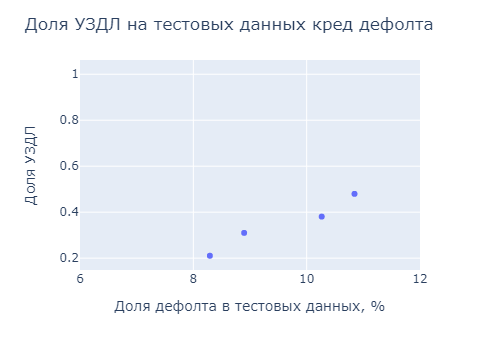

In [39]:
kwargs = dict(title='Доля УЗДЛ на тестовых данных кред дефолта', 
                x_title='Доля дефолта в тестовых данных, %', y_title='Доля УЗДЛ', 
                x_range=[6 , 12], 
                height= 350, width =500, 
                df = df_metrics[df_metrics['proba']>0.29])
    
fig_share_uzdl_cred = create_plot(cpShareUzdlvTestDefaul, **kwargs)
fig_share_uzdl_cred.show('png' if need_svg else '')

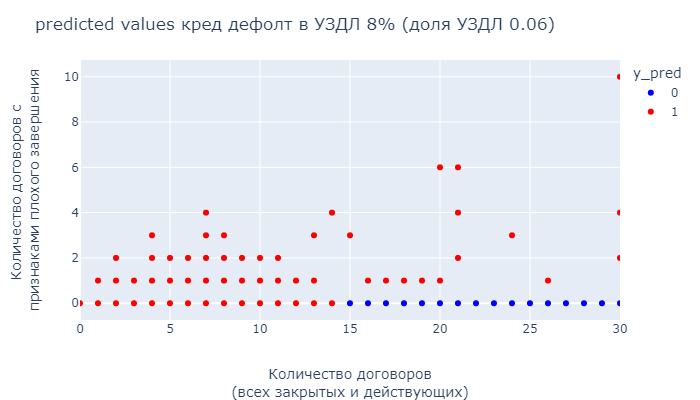

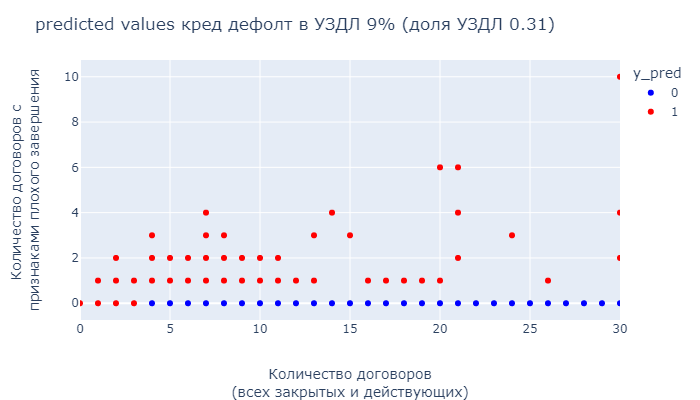

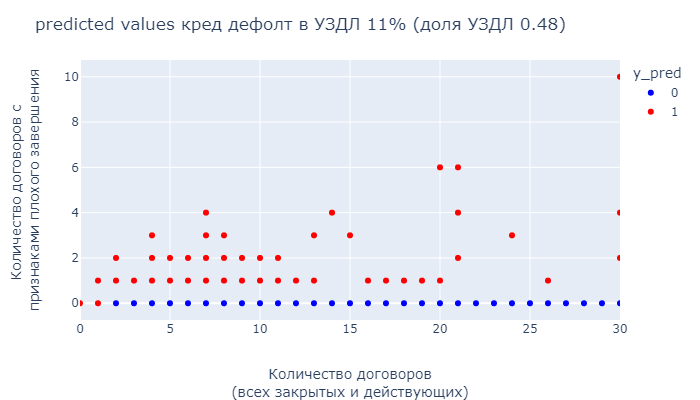

In [40]:
test_res = data_test.copy()
y_pred, y_prob = model_mvp.predict(test_res)
test_res['y_pred'] = y_pred.astype(str)
test_res['y_prob'] = y_prob

df = test_res.drop_duplicates(subset=['no_contracts_total', 'bad_reasons_closed', 'y_pred', 'y_prob'])

fig = show_pred_versus_shareDefaults(df_metrics, df,  8, title='predicted values кред дефолт в УЗДЛ')
fig_pred_values_cred = show_pred_versus_shareDefaults(df_metrics, df,9, title='predicted values кред дефолт в УЗДЛ')
fig = show_pred_versus_shareDefaults(df_metrics, df,11, title='predicted values кред дефолт в УЗДЛ')